In [2]:
"""Propagating 2D dynamics on the muller potential using OpenMM.
Currently, we just put a harmonic restraint on the z coordinate,
since OpenMM needs to work in 3D. This isn't really a big deal, except
that it affects the meaning of the temperature and kinetic energy. So
take the meaning of those numbers with a grain of salt.
"""
from openmm.unit import kelvin, picosecond, femtosecond, nanometer, dalton
import openmm as mm

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np

from energy_landscape import MullerForce, ModifiedMullerForce, landscape
import algorithm

import scipy.stats as st
# from matplotlib.path import Path
# from scipy.stats import gaussian_kde

from sys import getsizeof

In [3]:
np.random.seed(1)

# Update Algorithm Parameters
total_step = 10000
large_batch_size = 500
small_batch_size = 50
beta = 1
k = 50.0
boundary_frac = 0.75 

# Brownian simulation parameters
## each particle is totally independent, propagating under the same potential
nParticles = 1  
mass = 1.0 * dalton
temp = 750
temperature = temp * kelvin
friction = 100 / picosecond
timestep = 10.0 * femtosecond
step = 100
## Define initial point
sp_A = (np.random.rand(1, 3) * np.array([0.2, 0.1, 1])) + np.array([1.6, 0.1, 0])
startingPositions = sp_A 

# Brownian simulation set-up
system = mm.System()
pes = landscape('Modified_Muller')

for i in range(nParticles):
    system.addParticle(mass)
    pes.addParticle(i, [])
system.addForce(pes)

integrator = mm.LangevinIntegrator(temperature, friction, timestep)
context = mm.Context(system, integrator)

1 outer step: 500   | cent: [-0.82  1.35] | init: [1.68 0.17]


TypeError: ObsBoundReInit.update_position() got an unexpected keyword argument 'cent_prev'

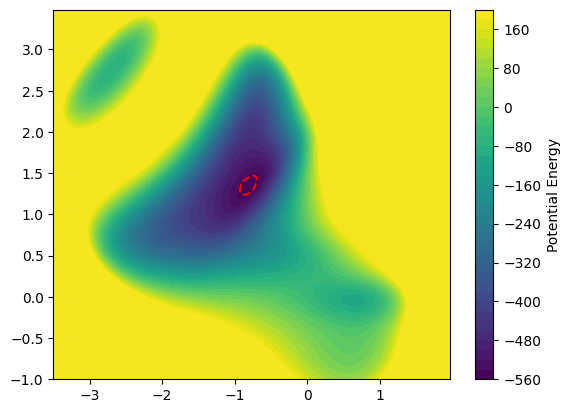

In [5]:
# Preparation to run simulations
traj_save = []
init_points_outer = []
init_points_inner = []
update_rates = []
v_save = []
cent = startingPositions[:,:2].T 
v = 0
iteration_counter = {}
#########################

ft=15
pes.plot(ax=plt.gca())

# Start simulation
remain_step = total_step
n=1 # outer loop counter


while remain_step > 0:
    # Initialization    
    context.setPositions(startingPositions)
    context.setVelocitiesToTemperature(temperature)
    init_points_outer.append(startingPositions[0][:2])
    
    # Outer iteration (Browninan Simulation)
    traj = np.zeros((large_batch_size,3))
    for i in range(large_batch_size):
        x = context.getState(getPositions=True).getPositions(asNumpy=True).value_in_unit(nanometer)   
        p = x[0]
        E = pes.potential(x=p[0], y=p[1])
        traj[i] = np.array([p[0], p[1], E])
        integrator.step(step)
    traj_save.append(traj)
    
    # Instantiation
    particle_outer = algorithm.ObsBoundReInit(traj, cent_prev=cent, inc_prev=v,
                                              delta=0.0001, beta=beta, k=k)
    
    # Secure boundary & centroid & last point & kernel (density gradient)
    boundary_path = particle_outer.get_contour_path(target_fraction=boundary_frac)
    kde_outer = particle_outer.kde()
    
    cent = particle_outer.cent
    last = particle_outer.last
    remain_step -= large_batch_size
    # print results
    print(f'{n} outer step: {total_step-remain_step}   | cent: {np.round(cent.flatten(),2)} \
| init: {np.round(init_points_outer[-1],2)}')

    # Decision block 
    ## Determine whether the centroid inside any boundary paths 
    ## Start inner loop after the decision
    ## If the centroid is outside all boundary paths, this while loop would be skipped!
    m=0 # inner loop counter

    while (particle_outer.increase(boundary_path, cent) != 0) and (remain_step > 0):
        # Instantiation
        particle_inner = algorithm.ObsBoundReInit(traj, cent_prev=cent, inc_prev=v,
                                                 delta=0.0001, beta=beta, k=k)
  
        
        # Update reinitialization point
        ## Update rate is amplified by the number of times the centroid is revisited
        
        density_grad = particle_inner.density_gradient(point=last, kde=kde_outer)
        p_new, upd = particle_inner.update_position(grad=density_grad, 
                                                    vn=v) 
        E_new = pes.potential(*p_new)
        startingPositions = np.vstack((p_new, E_new)).T
        
        # Save update rate for tracking 
        update_rates.append(upd)
        # Re-Initialization
        context.setPositions(startingPositions)
        context.setVelocitiesToTemperature(temperature)       
        init_points_inner.append(startingPositions[0][:2])
        # Inner iteration (Run Brownian Simulation)
        traj = np.zeros((small_batch_size,3))
        for i in range(small_batch_size):
            x = context.getState(getPositions=True).getPositions(asNumpy=True).value_in_unit(nanometer)   
            p = x[0]
            E = pes.potential(x=p[0], y=p[1])
            traj[i] = np.array([p[0], p[1], E]) 
            integrator.step(step)
        # cent = np.mean(traj[:,:2], axis=0)
        # last = traj[-1,:2].reshape(2,1)
    
        # Secure centroid & last point & v_n for the next run
        v_save.append(v)
        v += 1.0 #particle_inner.increase(boundary_path, cent)     
        cent = particle_inner.cent
        last = particle_inner.last
        # cent = np.mean(traj[:,:2], axis=0)
        # last = traj[-1,:2].reshape(2,1)
    
        remain_step -= small_batch_size
        # print results
        if (remain_step%200 == 0): #or (boundary_path.contains_point(cent) == False):
            print(f'    inner step: {total_step-remain_step} | cent: {np.round(cent.flatten(),2)} | \
init: {np.round(startingPositions[0][:2],2)} |  v_n: {v} | update: {np.round(upd,2)}')
        
        m+=1
        iteration_counter.update({n:m})
        if remain_step < 0:
            print('reached the max step')
            break
            
    # Reset v_n & init point 
    ## init point as last traj from newly found cluster  
    v=0 
    p_new = last #cent #particle.update_position()
    E_new = pes.potential(*p_new)
    startingPositions = np.vstack((p_new, E_new)).T
    n+=1

if np.sum(list(iteration_counter.values())) == len(update_rates):
    print('itertation number matching!!') 
else:
    print('iteration number NOT matching!!')
    

In [83]:
iteration_counter

{1: 4, 2: 30, 3: 51, 5: 32, 6: 4, 7: 9}

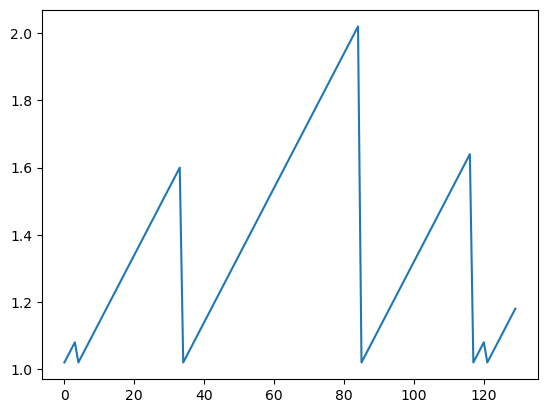

In [84]:
plt.plot(update_rates)

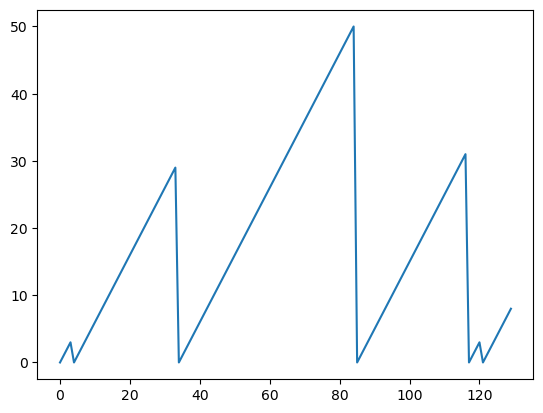

In [85]:
# plot v save
plt.plot(v_save)

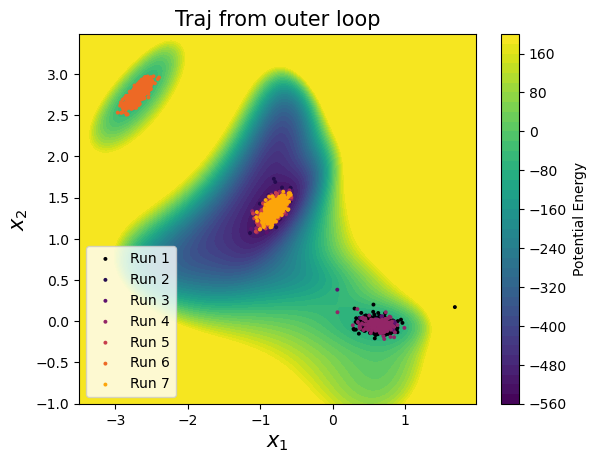

In [86]:
ft=15
e=0.2
traj_all = np.vstack(traj_save)
min_x, max_x = min(traj_all[:,0]), max(traj_all[:,0])
min_y, max_y = min(traj_all[:,1]), max(traj_all[:,1])
pes.plot(ax=plt.gca())
colors = cm.inferno(np.linspace(0, 0.8, len(traj_save)))
i=0
for n in range(len(traj_save)): 
    c = colors[n]
    x = traj_save[n][:,0]
    y = traj_save[n][:,1]
    plt.scatter(x, y, edgecolor='none', s=8, color=c, label=f'Run {i+1}')
    i += 1
plt.xlabel('$x_1$', fontsize=ft)
plt.ylabel('$x_2$', fontsize=ft)
plt.title('Traj from outer loop', fontsize=ft)
plt.legend(fontsize=ft-5, loc='lower left')
#plt.savefig(f'./figure/0403/dw_obsbd2_i{total_step}lb{large_batch_size}sb{small_batch_size}b{beta}k{k}.png', bbox_inches='tight', facecolor='w')
plt.show()

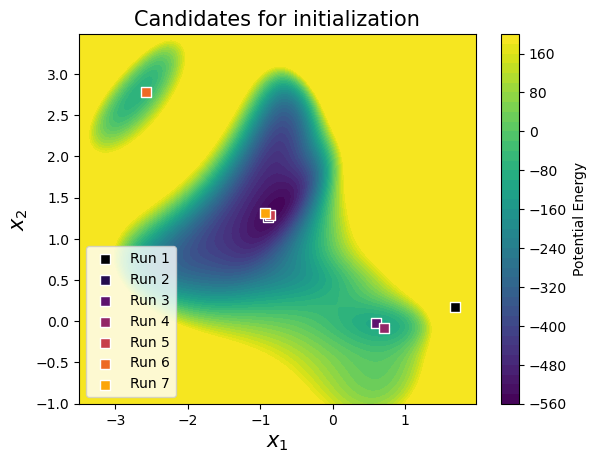

In [87]:
ft=15
e=0.2
traj_all = np.vstack(traj_save)
min_x, max_x = min(traj_all[:,0]), max(traj_all[:,0])
min_y, max_y = min(traj_all[:,1]), max(traj_all[:,1])
pes.plot(ax=plt.gca())
colors = cm.inferno(np.linspace(0, 0.8, len(init_points_outer)))
i=0
for n in range(len(init_points_outer)): 
    c = colors[n]
    x = init_points_outer[n][0]
    y = init_points_outer[n][1]
    plt.scatter(x, y, edgecolor='white', s=50, marker='s', color=c, label=f'Run {i+1}')
    i += 1
plt.xlabel('$x_1$', fontsize=ft)
plt.ylabel('$x_2$', fontsize=ft)
plt.title('Candidates for initialization', fontsize=ft)
plt.legend(fontsize=ft-5, loc='lower left')
#plt.savefig(f'./figure/0327/dw_obsbd2_i{total_step}lb{large_batch_size}sb{small_batch_size}b{beta}k{k}.png', bbox_inches='tight', facecolor='w')
plt.show()

/tmp/ipykernel_31818/4207407880.py:13: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x, y, edgecolor='white', s=50, marker='x', color=c, label=f'Run {i+1}')


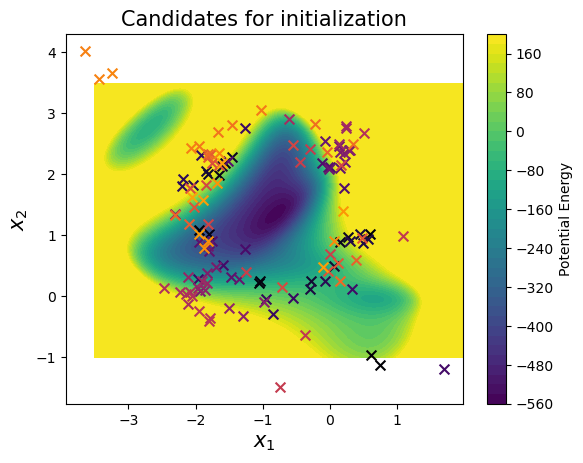

In [88]:
ft=15
e=0.2
traj_all = np.vstack(traj_save)
min_x, max_x = min(traj_all[:,0]), max(traj_all[:,0])
min_y, max_y = min(traj_all[:,1]), max(traj_all[:,1])
pes.plot(ax=plt.gca())
colors = cm.inferno(np.linspace(0, 0.8, len(init_points_inner)))
i=0
for n in range(len(init_points_inner)): 
    c = colors[n]
    x = init_points_inner[n][0]
    y = init_points_inner[n][1]
    plt.scatter(x, y, edgecolor='white', s=50, marker='x', color=c, label=f'Run {i+1}')
    i += 1
plt.xlabel('$x_1$', fontsize=ft)
plt.ylabel('$x_2$', fontsize=ft)
plt.title('Candidates for initialization', fontsize=ft)
#plt.legend(fontsize=ft-5, loc='lower left')
#plt.savefig(f'./figure/0327/dw_obsbd2_i{total_step}lb{large_batch_size}sb{small_batch_size}b{beta}k{k}.png', bbox_inches='tight', facecolor='w')
plt.show()

In [ ]:
# iteration = 120 #30
# batch_size = 40 #50
# np.random.seed(1)

# beta = 0.1 #0.15
# k = 4 #2.5
# thres = 0.5
# beta2 = 0.

# # each particle is totally independent, propagating under the same potential
# nParticles = 1  
# mass = 1.0 * dalton
# temp = 750
# temperature = temp * kelvin
# friction = 100 / picosecond
# timestep = 10.0 * femtosecond
# # Choose starting conformations uniform on the grid between (-1.5, -0.2) and (1.2, 2)
# sp_A = (np.random.rand(1, 3) * np.array([1.0, 0.35, 1])) + np.array([0.8, -0.5, 0])
# startingPositions = sp_A 
# ###############################################################################

# system = mm.System()
# pes = energy_landscape.ModifiedMullerForce(a2=-0.1, c2=-0.1, A2=500, X2=-0.5582, Y2=1.4417)
# for i in range(nParticles):
#     system.addParticle(mass)
#     pes.addParticle(i, [])
# system.addForce(pes)

# integrator = mm.LangevinIntegrator(temperature, friction, timestep)
# context = mm.Context(system, integrator)

# traj_all = np.zeros((batch_size*iteration, 3))
# init_points = np.zeros((iteration, 3))#[]
# coeffs = np.zeros((iteration,2))
# #for initialization
# #########################
# cent = sp_A[:,:2].T 
# inc = -1
# adap = 0
# #########################
# for n in range(iteration):
#     context.setPositions(startingPositions)
#     context.setVelocitiesToTemperature(temperature)
#     traj = np.zeros((batch_size,3))
#     for i in range(batch_size):
#         x = context.getState(getPositions=True).getPositions(asNumpy=True).value_in_unit(nanometer)   
#         p = x[0]
#         E = pes.potential(x=p[0], y=p[1])
#         traj[i] = np.array([p[0], p[1], E]) #p1
#         integrator.step(100)
        
#     init_points[n] = startingPositions     
#     traj_all[batch_size*n:batch_size*(n+1)] = traj
    
#     particle = reinit.ReInit(traj, cent_prev = cent, 
#                                 inc_prev= inc, adap_prev = adap, 
#                                 delta=0.0001, 
#                                 beta=beta, beta2=beta2, 
#                                 k=k, thres=thres)
#     cent = particle.cent

#     inc = particle.increase()
#     adap = particle.adaptive()
#     grad = particle.gradient_force()
#     coeff = particle.coeff()
#     coeffs[n] = coeff.T
#     p_new = particle.update_position()
#     E_new = pes.potential(*p_new)
#     startingPositions = np.vstack((p_new, E_new)).T